Local copy of the dataset file: /Users/lancastro/.keras/datasets/iris_training.csv
120,4,setosa,versicolor,virginica
6.4,2.8,5.6,2.2,2
5.0,2.3,3.3,1.0,1
4.9,2.5,4.5,1.7,2
4.9,3.1,1.5,0.1,0
Features: ['sepal_length', 'sepal_width', 'petal_length', 'petal_width']
Label: species
Instructions for updating:
Use `tf.data.experimental.make_csv_dataset(...)`.
Instructions for updating:
Colocations handled automatically by placer.


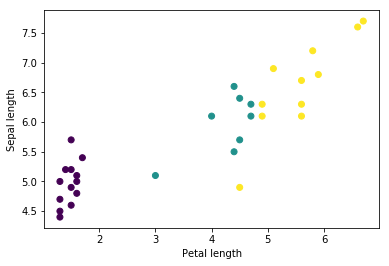

tf.Tensor(
[[4.6 3.4 1.4 0.3]
 [6.5 2.8 4.6 1.5]
 [6.1 2.8 4.  1.3]
 [5.5 2.4 3.8 1.1]
 [5.1 3.8 1.6 0.2]], shape=(5, 4), dtype=float32)
Prediction: [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
    Labels: [0 1 1 1 0 1 0 2 2 1 0 1 1 1 0 0 2 0 1 1 0 1 1 1 0 0 2 0 1 0 2 2]
Instructions for updating:
Use tf.cast instead.
Loss test: 0.9967171549797058
Step: 0, Initial Loss: 0.9967171549797058
Step: 1,         Loss: 0.9789007306098938
Epoch 000: Loss: 1.084, Accuracy: 49.167%
Epoch 050: Loss: 0.395, Accuracy: 93.333%
Epoch 100: Loss: 0.223, Accuracy: 96.667%
Epoch 150: Loss: 0.163, Accuracy: 99.167%
Epoch 200: Loss: 0.130, Accuracy: 98.333%


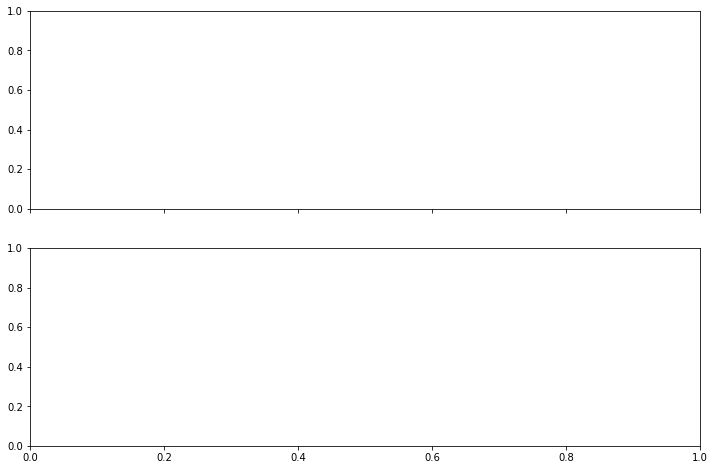

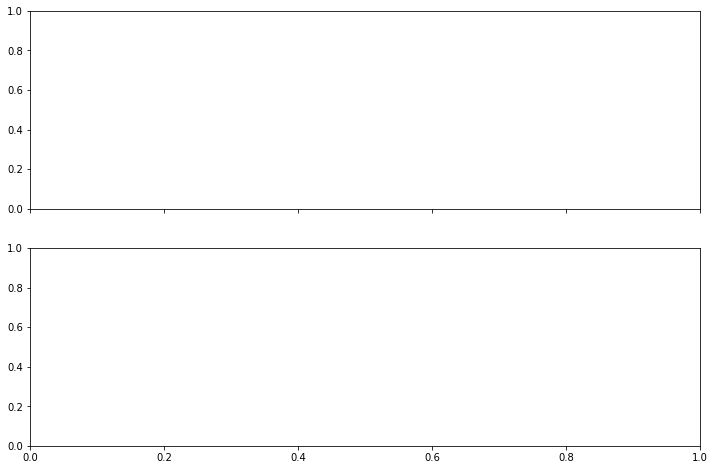

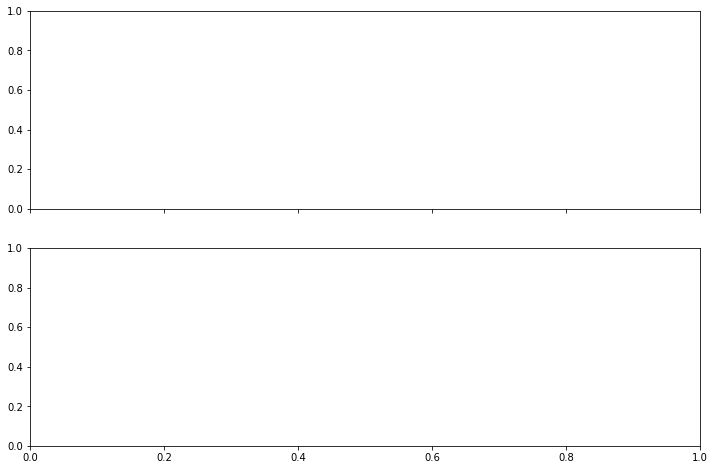

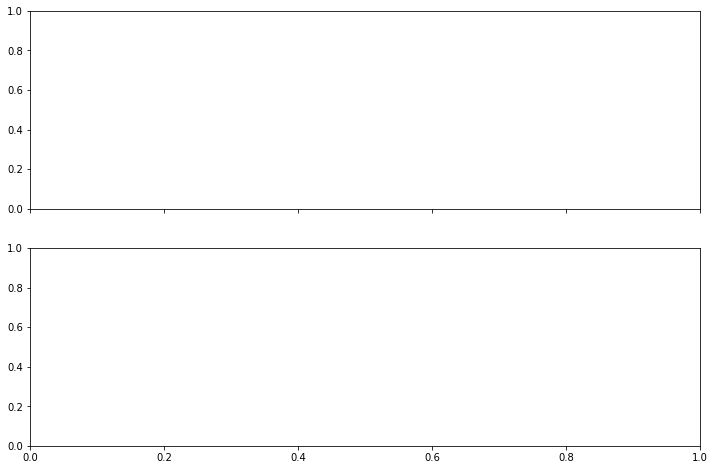

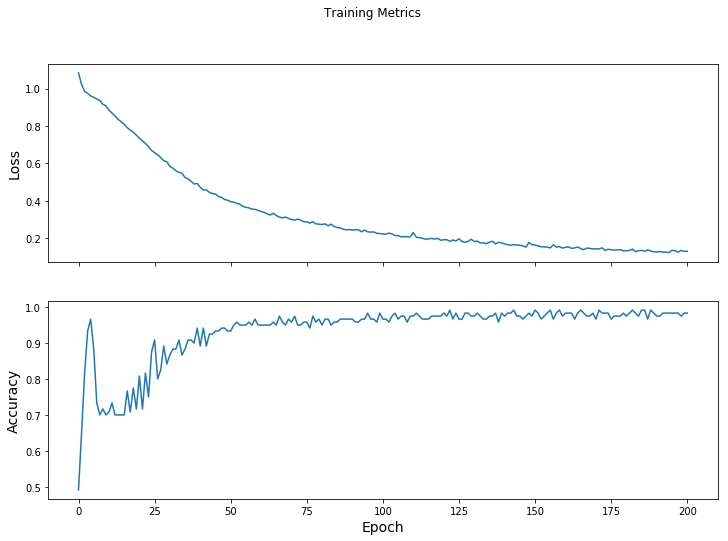

Test set accuracy: 0.967
Example 0 prediction: Iris setosa (98.2%)
Example 1 prediction: Iris versicolor (91.5%)
Example 2 prediction: Iris virginica (77.8%)


In [2]:
from __future__ import absolute_import, division, print_function, unicode_literals

import os
import matplotlib.pyplot as plt
import tensorflow as tf

tf.enable_eager_execution()

train_dataset_url = "https://storage.googleapis.com/download.tensorflow.org/data/iris_training.csv"
train_dataset_fp = tf.keras.utils.get_file(fname=os.path.basename(train_dataset_url),
                                           origin=train_dataset_url)

print("Local copy of the dataset file: {}".format(train_dataset_fp))

!head -n5 {train_dataset_fp}

# column order in CSV file
column_names = ['sepal_length', 'sepal_width', 'petal_length', 'petal_width', 'species']

feature_names = column_names[:-1]
label_name = column_names[-1]

print("Features: {}".format(feature_names))
print("Label: {}".format(label_name))

class_names = ['Iris setosa', 'Iris versicolor', 'Iris virginica']
batch_size = 32

train_dataset = tf.contrib.data.make_csv_dataset(
    train_dataset_fp,
    batch_size,
    column_names=column_names,
    label_name=label_name,
    num_epochs=1)

features, labels = next(iter(train_dataset))

features

plt.scatter(features['petal_length'].numpy(),
            features['sepal_length'].numpy(),
            c=labels.numpy(),
            cmap='viridis')

plt.xlabel("Petal length")
plt.ylabel("Sepal length")
plt.show()

def pack_features_vector(features, labels):
  """Pack the features into a single array."""
  features = tf.stack(list(features.values()), axis=1)
  return features, labels

train_dataset = train_dataset.map(pack_features_vector)

features, labels = next(iter(train_dataset))
print(features[:5])

model = tf.keras.Sequential([
  tf.keras.layers.Dense(10, activation=tf.nn.relu, input_shape=(4,)),  # input shape required
  tf.keras.layers.Dense(10, activation=tf.nn.relu),
  tf.keras.layers.Dense(3)
])

predictions = model(features)
predictions[:5]

tf.nn.softmax(predictions[:5])

print("Prediction: {}".format(tf.argmax(predictions, axis=1)))
print("    Labels: {}".format(labels))

def loss(model, x, y):
  y_ = model(x)
  return tf.losses.sparse_softmax_cross_entropy(labels=y, logits=y_)


l = loss(model, features, labels)
print("Loss test: {}".format(l))

def grad(model, inputs, targets):
  with tf.GradientTape() as tape:
    loss_value = loss(model, inputs, targets)
  return loss_value, tape.gradient(loss_value, model.trainable_variables)

optimizer = tf.train.GradientDescentOptimizer(learning_rate=0.01)
global_step = tf.Variable(0)

loss_value, grads = grad(model, features, labels)

print("Step: {}, Initial Loss: {}".format(global_step.numpy(),
                                          loss_value.numpy()))
optimizer.apply_gradients(zip(grads, model.trainable_variables), global_step)
print("Step: {},         Loss: {}".format(global_step.numpy(),
                                          loss(model, features, labels).numpy()))

## Note: Rerunning this cell uses the same model variables

from tensorflow import contrib
tfe = contrib.eager

# keep results for plotting
train_loss_results = []
train_accuracy_results = []

num_epochs = 201

for epoch in range(num_epochs):
  epoch_loss_avg = tfe.metrics.Mean()
  epoch_accuracy = tfe.metrics.Accuracy()

  # Training loop - using batches of 32
  for x, y in train_dataset:
    # Optimize the model
    loss_value, grads = grad(model, x, y)
    optimizer.apply_gradients(zip(grads, model.trainable_variables),
                              global_step)

    # Track progress
    epoch_loss_avg(loss_value)  # add current batch loss
    # compare predicted label to actual label
    epoch_accuracy(tf.argmax(model(x), axis=1, output_type=tf.int32), y)

  # end epoch
  train_loss_results.append(epoch_loss_avg.result())
  train_accuracy_results.append(epoch_accuracy.result())

  if epoch % 50 == 0:
    print("Epoch {:03d}: Loss: {:.3f}, Accuracy: {:.3%}".format(epoch,
                                                                epoch_loss_avg.result(),
                                                                epoch_accuracy.result()))
    
    fig, axes = plt.subplots(2, sharex=True, figsize=(12, 8))
fig.suptitle('Training Metrics')

axes[0].set_ylabel("Loss", fontsize=14)
axes[0].plot(train_loss_results)

axes[1].set_ylabel("Accuracy", fontsize=14)
axes[1].set_xlabel("Epoch", fontsize=14)
axes[1].plot(train_accuracy_results)
plt.show()

test_url = "https://storage.googleapis.com/download.tensorflow.org/data/iris_test.csv"

test_fp = tf.keras.utils.get_file(fname=os.path.basename(test_url),
                                  origin=test_url)

test_dataset = tf.contrib.data.make_csv_dataset(
    test_fp,
    batch_size,
    column_names=column_names,
    label_name='species',
    num_epochs=1,
    shuffle=False)

test_dataset = test_dataset.map(pack_features_vector)

test_accuracy = tfe.metrics.Accuracy()

for(x, y) in test_dataset:
  logits = model(x)
  prediction = tf.argmax(logits, axis=1, output_type=tf.int32)
  test_accuracy(prediction,y)
  
print("Test set accuracy: {:.3}".format(test_accuracy.result()))

tf.stack([y, prediction], axis=1)

predict_dataset = tf.convert_to_tensor([
    [5.1, 3.3, 1.7, 0.5,],
    [5.9, 3.0, 4.2, 1.5,],
    [6.9, 3.1, 5.4, 2.1]
])

predictions = model(predict_dataset)

for i, logits in enumerate(predictions):
  class_idx = tf.argmax(logits).numpy()
  p = tf.nn.softmax(logits)[class_idx]
  name = class_names[class_idx]
  print("Example {} prediction: {} ({:4.1f}%)".format(i, name, 100*p))